# Full calculation of matter power spectrum P(k) using CLASS

This notebook uses the excellent [CLASS](http://class-code.net/) code to do a full realistic calculation of the matter power spectrum in the Early Universe

In [1]:
%%bash
if ! python3 -c "import classy" 2>/dev/null; then
    git clone --depth=1 https://github.com/lesgourg/class_public.git
    cd class_public
    PYTHON=python3 make -j all >/dev/null
fi

In [2]:
from classy import Class

In [3]:
from math import pi
import numpy as np
from scipy.optimize import fsolve
from scipy.interpolate import interp1d

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = {'retina','png'}

In [5]:
# create instance of the class "Class"
LambdaCDM = Class()

Prepare the list of conformal momenta of interest and variables to store the parameters and results of each simulations

In [6]:
kk_h = np.logspace(-4,np.log10(3.5),1000) # list of k in h/Mpc
simulations = []

In [7]:
## Runs simulations for given parameter set and stores the result in pars and Pk
def run_Class_Pk(pp):
    LambdaCDM.struct_cleanup()
    LambdaCDM.empty()
    LambdaCDM.set(pp)
    LambdaCDM.set({'output':'mPk', 'P_k_max_1/Mpc':kk_h[-1]})
    LambdaCDM.compute()
    # get P(k) at redhsift z=0
    Pk = [] # P(k) in (Mpc/h)**3
    h = LambdaCDM.h() # get reduced Hubble for conversions to 1/Mpc
    for k_h in kk_h:
        Pk.append(LambdaCDM.pk(k_h*h, 0.)*h**3) # function .pk(k,z)
    return (LambdaCDM.pars, Pk)

Run simulations and add to the `simulations` list. Here we have the default CDM parameters.

Note, $\Omega_\Lambda$ is calculated automatically to satisfy
$$
\Omega_b+\Omega_{cdm}+\Omega_{rad}+\Omega_k = 1
$$
See the (extremely) complete list of possible cosmologicla parameters in [explanatory.ini](https://github.com/lesgourg/class_public/blob/master/explanatory.ini) of the [CLASS](http://class-code.net/) package, and references to original publications.

By convention `omega_cdm` is defined as $\Omega_{cdm}h^2$ (and similar). Note also that $\Omega_\gamma h^2$ and not $\Omega_{rad}$ is used as the input here.

In [8]:
simulations.append(
    run_Class_Pk({'omega_g': 2.473e-5,
                 'omega_b': 0.032032,
                 'omega_cdm': 0.12038,
                 'h': 0.67556,
                 'Omega_k': 0.0,
                 'A_s': 2.215e-9,
                 'n_s': 0.9619}) )

You can run more simulations with other sets of parameters:

In [9]:
simulations.append(
    run_Class_Pk({'omega_g': 2.473e-5,
                 'omega_b': 0.01,
                 'omega_cdm': 0.12038+0.032032-0.01,
                 'h': 0.67556,
                 'Omega_k': 0.0,
                 'A_s': 2.215e-9,
                 'n_s': 0.9619}) )

Plot the results!

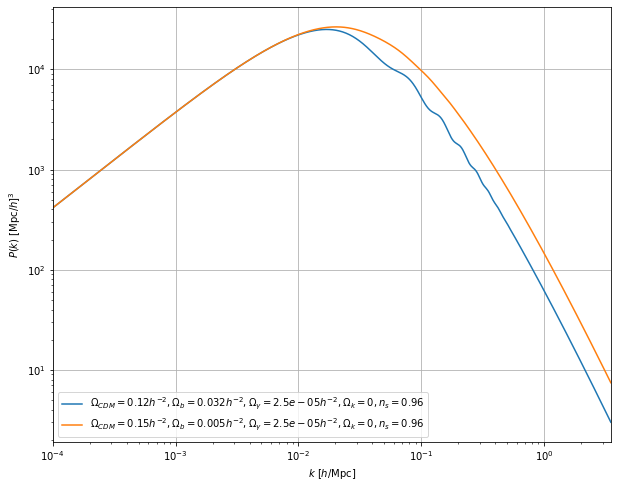

In [10]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.xlim(kk_h[0], kk_h[-1])
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k)\ [\mathrm{Mpc}/h]^3$')
plt.grid()
for pars, Pk in simulations:
    plt.loglog(kk_h, Pk,
               label="$\Omega_{CDM}=%4.2gh^{-2}, \Omega_b=%4.2gh^{-2}, \Omega_\gamma=%4.2gh^{-2}, \Omega_k=%4.2g, n_s=%4.2g$"%(
                      pars['omega_cdm'], pars['omega_b'], pars['omega_g'], pars['Omega_k'], pars['n_s']))
plt.legend()